## Постановка задачи

Задание согласно варианту №2:

Отфильтровать вейвлетами Хаара функцию $f(x)=e^x$, применив пороговую фильтрацию. Степень порога выбрать произвольную.

Рассчитать:
- квадратичное отклонение отфильтрованного сигнала от исходно и зашумленного (standart derivation)
- степень зашумленности полученных сигналов (NRC)

## Ход работы

Построим исходную функцию $f(x)=e^x$ и применим зашумление. Для этого создаем вектор, число в каждой точке которого возьмем из равномерного распределения на $x\in[-10, 10]$:

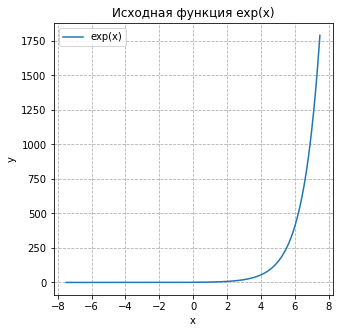

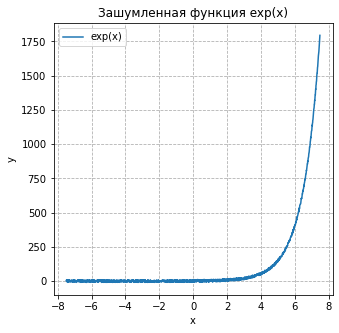

In [6]:
from src import src

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-7.5, 7.5, 0.01)
y = np.exp(x)
noise = [np.random.uniform(-10, 10) for _ in y]
ny = y + noise

def plotexp(x, y, title="exp(x)", labels=None):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    for xi, yi, label in zip(x, y, labels or ['' for _ in x]):
        plt.plot(xi, yi, label=label)
    plt.grid(linestyle='--')
    plt.legend()
    plt.show()

plotexp([x], [y], "Исходная функция exp(x)", ["exp(x)"])
plotexp([x], [ny], "Зашумленная функция exp(x)", ["exp(x)"])


Осуществим сжатие исходного вектора при помощи вейвлетов Хаара. Проведем 7 итераций алгоритма, итоговый вектор будет в $2 ^ 7 = 128$ раз меньше исходного:

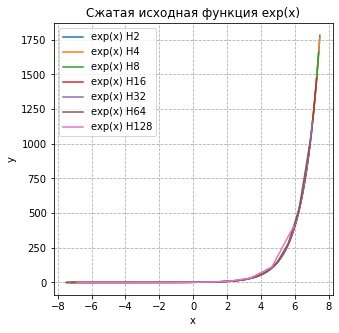

In [7]:
n = 7
fx, fy = src.multi_h_filter(n, x, y)

plotexp(
    fx, fy,
    "Сжатая исходная функция exp(x)",
    [f"exp(x) H{2 ** (idx + 1)}"for idx, _ in enumerate(y)]
)

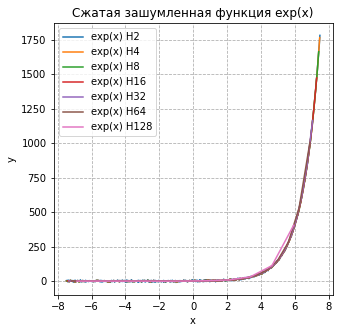

In [3]:
fx, nfy = src.multi_h_filter(n, x, ny)

plotexp(
    fx, nfy,
    "Сжатая зашумленная функция exp(x)",
    [f"exp(x) H{2 ** (idx + 1)}"for idx, _ in enumerate(y)]
)

Рассчитаем standart derivation для полученных зашумленного и незашумленного векторов:

$$\sigma = \sqrt{\dfrac{1}{n}\sum^{n}_{i=0}(y_i - \hat{y}) ^ 2}$$

Где:

$$\hat{y} = \dfrac{1}{n}\sum^{n}_{i=0}y_i$$

In [4]:
print(
    "Среднеквадратичная ошибка для исходного вектора:",
    np.round(src.st_der(fy[-1]), 3)
)
print(
    "Среднеквадритичная ошибка для зашумленного вектора",
    np.round(src.st_der(nfy[-1]), 3)
)

Среднеквадратичная ошибка для исходного вектора: 116.269
Среднеквадритичная ошибка для зашумленного вектора 116.421


Рассчитаем зашумленность вектора:
$$NRC = 1- \dfrac{y^2}{y'^2}$$

In [5]:
print(
    "Зашумленность для исходного вектора:",
    np.round(src.nrc(np.exp(fx[-1]), fy[-1]), 3),
)
print(
    "Зашумленность для зашумленного вектора",
    np.round(src.nrc(np.exp(fx[-1]), nfy[-1]), 3),
)

Зашумленность для исходного вектора: 0.874
Зашумленность для зашумленного вектора 0.871


## Вывод

В ходе выполнения работы вейвлеты Хаара были применены для сжатия и фильтрации функции $f(x)=e ^ x$ как с зашумлением, так и без. Судя по полученным коэффициентам зашумления после работы алгоритма не была внесена существенная ошибка. Более того, внесенный шум удалось скомпенсировать при помощи выполненных преобразований.











## Приложение

Исходный код модуля src.py:

```python
import numpy as np


# Среднеквадратичное отклонение - для оценки работы алгоритма
def st_der(A: np.ndarray):
    return np.mean((A - np.mean(A)) ** 2) ** (1/2)


# Оценка степени зашумления
def nrc(A: np.ndarray, B: np.ndarray):
    return np.sum(A ** 2) / np.sum(B ** 2)


# Для подсчета MSE надо бы иметь последовательности одинаковой длины
def expand(A: np.ndarray, times: int = 2):
    return np.array(
        list(
            e
            for elem in A
            for e in [elem] * times
        )
    )


# Позволит групировать последовтельность по N последовательных элементов
def grouper(n, iterable):
    args = [iter(iterable)] * n
    return zip(*args)


# Матрица хаара для наименьшего шага преобразования
H2 = np.array(
    [[1, 1], [1, -1]]
) * 1/2


# Шаг фильтрации хаара для одномерной последовательности
def h_filter(sequence: np.ndarray):
    res = list(np.dot(chunk, H2) for chunk in grouper(2, sequence))

    return np.transpose(res)


def multi_h_filter(n, xi, yi):
    x, y = list(), list()
    for _ in range(n):
        xi, _ = h_filter(xi)
        yi, _ = h_filter(yi)

        x.append(xi)
        y.append(yi)

    return x, y

```